Voici le projet d'OCVX du groupe de Hadrien Berthier, Axel Petit et Franck Thang

Ce projet est rélalisé en python 3, et utilisera les bibliothèques scipy numpy et panda

Ce document fait objet de rapport, en plus du code il comportera des explications et des annotations.

In [14]:
import warnings
import time
import numpy as np
import scipy as sc
import math
import pandas as pd
from matplotlib import pyplot as plt
from numpy import linalg as LA
from scipy import misc

In [15]:
def plot_2d(ob_function, xmin=-2, xmax=2, ymin=-2, ymax=2, nb_pts_h=50, nb_pts_v=50):
    x1 = np.linspace(xmin, xmax, nb_pts_h)
    x2 = np.linspace(ymin, ymax, nb_pts_v)
    X, Y = np.meshgrid(x1, x2)
    Z = ob_function(np.stack((X,Y), axis=0))
    plt.contour(X, Y, Z, cmap='RdGy')

In [16]:
def gradient_descent(x, ob_function, d_direction, 
                     rate=(lambda x, y: 0.01),
                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                     tolerance=0.0001, max_iter=1000,
                     plot_f=(lambda x, y: None)):
    """Gradient Descent.
    
    Computes minimal value of a convex function and local minimum of none convex function.
    
    Args:
        x (ndarray): initial starting point for descent.
        ob_function: objective function of optimisation problem, has input ndarray and outputs float.
        d_direction: function computing descent direction, outputs ndarray.
        rate: function computing learning rate, outputs float.
        decay_function: function computing decay, outputs float.
        tolerance (float): slack tolerance.
        max_iter (int): upper bound on number of iterations.      
        plot_f: plotting function for iteration points.
         
    Output:
        (int, int) minimizer, minimal value.
        
    """
    n_iter = 0
    decay = tolerance + 10  # Make sure that we get into first loop
    y = ob_function(x)
    while decay > tolerance and n_iter < max_iter:
        var_rate = rate(n_iter)
        x = x - var_rate * d_direction(ob_function, x)
        tmp_y = ob_function(x)
        decay = decay_function(y, tmp_y)
        y = tmp_y
        n_iter += 1
        plot_f(x, y)
        #print("var_rate:", var_rate)
    msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
    print(msg.format(n_iter, x.flatten(), y[0], decay))
    return (x, y, n_iter) if decay <= tolerance else warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)

In [17]:
def partial_derivative(ob_function, point, var=0):
    args = point
    def wraps(x):
        args[var] = x
        return ob_function(args)
    return misc.derivative(wraps, point[var], dx=1e-6)

In [18]:
def d_gd(ob_function, x):
    dim = x.shape[0]
    gradient = partial_derivative(ob_function, x, 0)
    for i in range(1, dim):
        gradient = np.vstack((gradient, partial_derivative(ob_function, x, i)))
    return gradient

In [19]:
def d_sgd(ob_function, x):
    dim = x.shape[0]
    sdescent = np.array([0]*dim, dtype=float).reshape(-1, 1)
    max_diff, imax_diff = sdescent[0], 0
    for i in range(dim):
        diff_i = abs(partial_derivative(ob_function, x, i))
        if  diff_i[0] > max_diff:
            imax_diff, max_diff = i, diff_i
    sdescent[imax_diff] = max_diff 
    return sdescent      

In [20]:
def d_sgd_l2(ob_function, x):
    dim = x.shape[0]
    sdescent = np.array([0]*dim, dtype=float).reshape(-1, 1)
    max_diff, imax_diff = sdescent[0], 0
    for i in range(dim):
        diff_i = LA.norm(partial_derivative(ob_function, x, i))
        if  diff_i > max_diff:
            imax_diff, max_diff = i, diff_i
    sdescent[imax_diff] = max_diff 
    return sdescent      

In [21]:
class backtracking():
    def __init__(self, alpha=0.01, beta=0.8, max_iter=100):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = max_iter
    def __call__(self, f, x, dir_x, n_iter=None):
        n_while = 0
        t = 1
        x = x.reshape(1, -1)
        grad_f = gradient(f, x)
        while f(x + t*dir_x) > f(x) + self.alpha*t*grad_f.dot(dir_x.T) and n_while < self.max_iter:
            t = self.beta*t
            n_while += 1
        return t

In [22]:
def generate_family_fc(theta=1):
    return lambda x: (1/2)*x[0]**2 + (1/2)*theta*x[1]**2

In [23]:

iterations = []
#for i in range(1, 21):
#(lambda decay, iteration: (1/(1 + decay + iteration)))
#    print("Iteration", i)
f = generate_family_fc(2)

x_star, p_star, n_iter = gradient_descent(np.array([[1], [1]], dtype=float), f, d_sgd_l2, rate=(lambda x,y: 0.1),plot_f=(lambda x, y:plt.scatter(x[0], x[1], c='k')))
iterations.append(n_iter)
plot_2d(f)

TypeError: <lambda>() missing 1 required positional argument: 'y'

In [24]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print("lrate:", lrate)
    return lrate


In [25]:
def exp_decay(t):
   initial_lrate = 0.5
   k = 0.1
   lrate = initial_lrate * np.exp(-k*t)
   return lrate

 Iteration nu. = 45
 approx. = [0.18027496 0.08978859]
 ob value = 0.024311520295611653
 and decay = 9.98981592902938e-05.


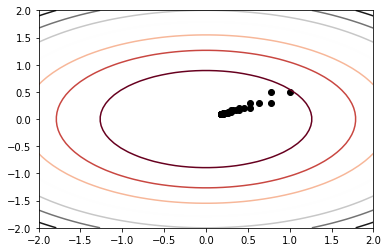

In [26]:
#plt.figure(figsize=(15,15))
#plot_2d(objective_2d)
iterations = []
f = generate_family_fc(2)

x_star, p_star, n_iter = gradient_descent(np.array([[1], [1]], dtype=float), f, d_sgd_l2, rate=exp_decay, plot_f=(lambda x, y:plt.scatter(x[0], x[1], c='k')))
iterations.append(n_iter)
plot_2d(f)

In [67]:
def nesterov_descent(func, rate, gradient_func, init_x, plot_f=(lambda x, y: None), delta_x=0.0005, epsilon=0.05):
    x = init_x

    lambda_prev = 0
    lambda_curr = 1
    gamma = 1
    y_prev = x

    gradient = gradient_func(func, x)
    num_iter = 0

    while np.linalg.norm(gradient) >= epsilon:
        y_curr = x - rate * gradient
        x = (1 - gamma) * y_curr + gamma * y_prev
        y_prev = y_curr

        lambda_tmp = lambda_curr
        lambda_curr = (1 + math.sqrt(1 + 4 * lambda_prev * lambda_prev)) / 2
        lambda_prev = lambda_tmp

        gamma = (1 - lambda_prev) / lambda_curr
        gradient = gradient_func(func, x)
        num_iter += 1
        plot_f(x, y_curr)
    msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
    print(msg.format(num_iter, x.flatten(), y_prev[0], lambda_curr))
    return x, num_iter

 Iteration nu. = 22
 approx. = [0.0755982  0.04025462]
 ob value = [0.10583644]
 and decay = 6.982427415989093.


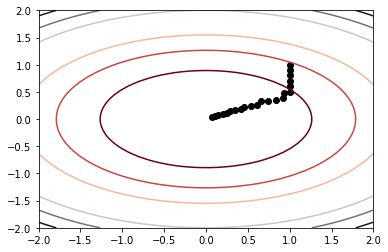

In [68]:
x, num_iter = nesterov_descent(f, 0.1, d_sgd_l2, np.array([[1], [1]], dtype=float), plot_f=(lambda x, y:plt.scatter(x[0], x[1], c='k')))

plot_2d(f)

In [107]:
def adam_optimization(func, gradient_func, theta_0, plot_f, alpha=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
    # Initialization
    m_t = 0 
    v_t = 0 
    t = 0
    g_t = gradient_func(func, theta_0)
    
    while np.linalg.norm(g_t) >= epsilon:
        t+=1
        g_t = gradient_func(func, theta_0)
        m_t = beta_1*m_t + (1-beta_1)*g_t #updates the moving averages of the gradient
        v_t = beta_2*v_t + (1-beta_2)*(g_t*g_t) #updates the moving averages of the squared gradient
        m_cap = m_t/(1-(beta_1**t)) #calculates the bias-corrected estimates
        v_cap = v_t/(1-(beta_2**t)) #calculates the bias-corrected estimates
        theta_0 = theta_0 - (alpha*m_cap)/(np.sqrt(v_cap)+epsilon) #updates the parameters
        plot_f(theta_0, func(theta_0))
            
    msg = " Iteration nu. = {}\n approx. = {}\n"
    print(msg.format(t, x.flatten()))
    return theta_0, t

 Iteration nu. = 676
 approx. = [0.0755982  0.04025462]



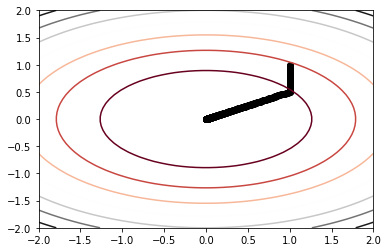

In [108]:
adam_optimization(f, d_sgd_l2, np.array([[1], [1]], dtype=float), plot_f=(lambda x, y:plt.scatter(x[0], x[1], c='k')))
plot_2d(f)